# CTA200: Final Project - Jessica Patel

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

plt.rcParams["figure.figsize"] = (7, 7)
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

### Constants

In [9]:
G = 6.67e-8 # Newton's gravitational constant in cm3/g/s2

m_m = 7.349e25 # Lunar mass in grams
m_s = 1.98e33 # Solar mass in grams
m_e = 5.97e27 # Earth mass in grams

r_e = 6371 * 1e5 # Radius of Earth (converted from km to cm)

a_m0 = 0.3885e6 * 1e5 # Semi-major axis of Lunar orbit in present day in cm
a_e0 = 1.49e8 * 1e5 # Semi-major axis of Earth orbit in present day in cm

k2 = 0.298 # Love number of Earth
q = 11.5 # Tidal quality factor

i_e = 0.3299 * m_e * r_e**2 # Earth's moment of inertia
lod = 86164 # Length of sidereal day in s
o_e = (2 * np.pi)/lod # Angular velocity of Earth

### Step 1 - Calculating initial values in cgs system

In [10]:
l_e0 = m_e * np.sqrt(G * (m_s + m_e) * a_e0) # Initial orbital angular momentum of Earth
s_e0 = i_e * o_e # Initial spin angular momentum of Earth
l_m0 = m_m * np.sqrt(G * (m_e + m_m) * a_m0) # Initial orbital angular momentum of Moon

print(l_e0, s_e0, l_m0)

2.6482783623404096e+47 5.829427067103106e+40 2.9082422525409362e+41


### Step 2: Finding present day values of tidal torques

In [11]:
# Using equation 4 with initial values:
t_m0 = (3 * G * m_m**2)/(2*a_m0) * (r_e/a_m0)**5 * k2/q  # Initial lunar tidal torque

# Using equation 5 
t_s0 = t_m0/4.7 # Initial solar tidal torque

print(t_m0, t_s0)

4.274485990601928e+23 9.094651043833889e+22


### Step 3: Calculating time-scales for each equation in *years*

In [12]:
# Equation 1
tau_le = (l_e0/t_s0) / 3.1536e7

# Equation 2
tau_se = (-s_e0/(t_s0 + t_m0)) / 3.1536e7

# Equation 3
tau_lm = (l_m0/t_m0) / 3.1536e7

print(tau_le, tau_se, tau_lm)

9.233598472352002e+16 -3565811410.936737 21574466981.346165


### Step 4: Creating function that evaluates RHS of equations 1-3

In [13]:
def T_moon(a_moon): 
    """ Calculates lunar tidal torque.
    
    Parameter:
    a_moon: Semi-major axis of Moon's orbit at time t.
    
    Returns:
    Lunar tidal torque.
    """
    return (3 * G * m_m**2)/(2*a_moon) * (r_e/a_moon)**5 * k2/q

def T_sun(a_moon):
    """ Calculates solar tidal torque.
    
    Parameter:
    a_moon: Semi-major axis of Moon's orbit at time t.
    
    Returns:
    Solar tidal torque.
    """
    return (1/4.7) * (a_moon/a_m0)**6 * T_moon(a_moon)
    
def ODES(t, y):
    """
    Gives right hand side of ODE's.
    
    Parameters:
    t: time
    y: array of [L_earth, S_earth, L_moon]
    
    Returns:
    Right hand side of ODE's.
    """
    LE, SE, LM = y
    
    a_moon = (LM/m_m)**2 / (G*(m_e+m_m)) # Solved for using equation 8
    
    return [T_sun(a_moon), -T_sun(a_moon)-T_moon(a_moon), T_moon(a_moon)]

### Step 5: Integrating back in time using Scipy's solve_ivp() and plotting

In [14]:
%%time

# Initial conditions taken from Step 1
y_i = [l_e0, s_e0, l_m0]

# Error tolerances absolute for each parameter and relative
atol = [3.e-14, 3.e-14, 3.e-14]
rtol = 3.e-14

# Times to evaluate the solution at
t_max = -6.3e16 # seconds (considering 2 billion years in the past)
t_samp = 10000000 # Number of samples - 7
t_eval = np.linspace(0, t_max, t_samp)

t_span = [0, t_max]

# Solving
sol_LE, sol_SE, sol_LM = solve_ivp(fun=lambda t, y: ODES(t, y), t_span=t_span, y0=y_i, t_eval=t_eval, atol=atol, rtol=rtol).y

Wall time: 1.16 s


In [15]:
print("LE = ", sol_LE)
print()
print("SE = ", sol_SE)
print()
print("LM = ", sol_LM)
print()

# Total angular momentum: Checking that it stays nearly constant
tot = sol_LE + sol_SE + sol_LM
error = (tot - tot[0])/tot[0]
print("Error = ", error)
print()

# Total angular momentum in Earth-Moon system: Checking how much it changes
tot_EM = sol_SE + sol_LM
frac_change = (tot_EM - tot_EM[0])/tot_EM
print("Fractional change = ", frac_change)

LE =  [2.64827836e+47 2.64827836e+47 2.64827836e+47 ... 2.64827831e+47
 2.64827831e+47 2.64827831e+47]

SE =  [5.82942707e+40 5.82942739e+40 5.82942772e+40 ... 2.62644929e+41
 2.66416855e+41 2.74826927e+41]

LM =  [2.90824225e+41 2.90824223e+41 2.90824220e+41 ... 9.12333725e+40
 8.74614475e+40 7.90513758e+40]

Error =  [ 0.00000000e+00 -3.06348202e-16 -1.53174101e-16 ...  5.51426764e-15
  5.66744174e-15  7.81187915e-15]

Fractional change =  [0.00000000e+00 1.64117074e-09 3.28234147e-09 ... 1.34504034e-02
 1.34504050e-02 1.34504066e-02]


In [16]:
# Creating time axis to plot over
s_Gy = 3.15e7*1e9 # converting seconds to billion years
t_axis = t_eval[:len(sol_LE)]/s_Gy

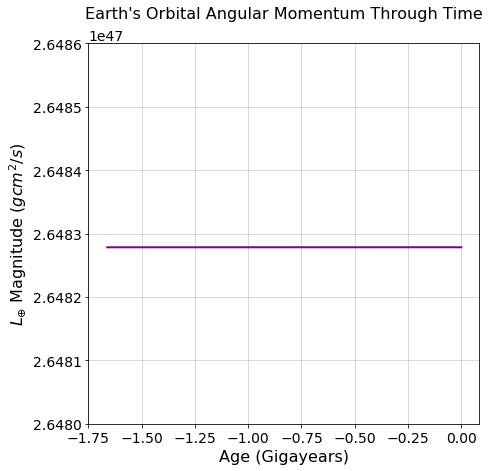

In [53]:
plt.plot(t_axis, sol_LE, c = 'purple', linewidth = 2)
plt.title('Earth\'s Orbital Angular Momentum Through Time', pad = 25)
plt.xlabel('Age (Gigayears)')
plt.ylabel('$L_{\oplus}$ Magnitude ($g cm^2/s$)')
plt.ylim(2.648e+47, 2.6486e+47)
plt.xlim(-1.75,)
plt.grid(alpha = 0.6)
plt.savefig("LE.pdf", bbox_inches = "tight")

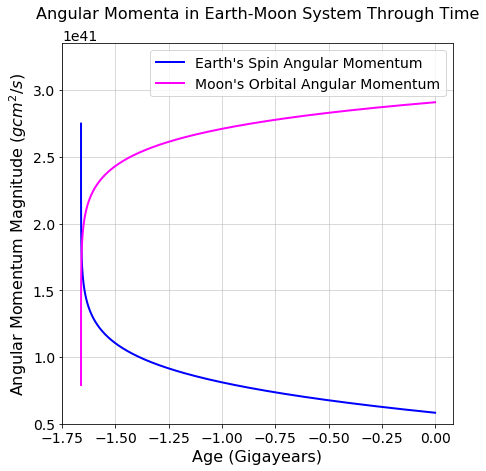

In [18]:
plt.plot(t_axis, sol_SE, label = 'Earth\'s Spin Angular Momentum', c = 'blue', linewidth = 2)
plt.plot(t_axis, sol_LM, label = "Moon's Orbital Angular Momentum", c = 'fuchsia', linewidth = 2)
plt.title('Angular Momenta in Earth-Moon System Through Time', pad = 25)
plt.xlabel('Age (Gigayears)')
plt.ylabel('Angular Momentum Magnitude ($g cm^2/s$)')
plt.grid(alpha = 0.6)
plt.xlim(-1.75,)
plt.ylim(0.5e41, 3.35e41)
plt.legend(fontsize = 14, loc = 'upper right')
plt.savefig("SE_LM.pdf")

In [19]:
print('Moon Age (Gyr): ', t_axis[-1])

Moon Age (Gyr):  -1.6614709661470966


### Step 6: Plotting Moon's semi-major axis over time

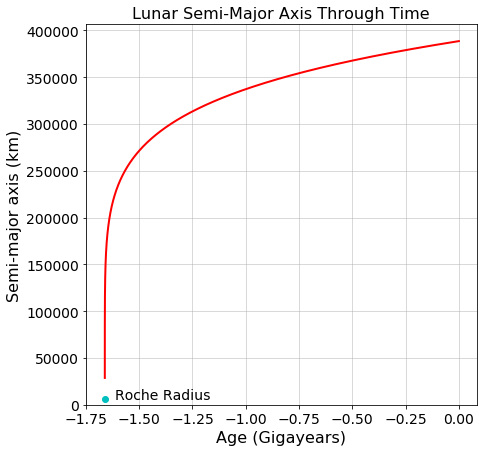

In [48]:
a_moon_t = (sol_LM/m_m)**2 / (G*(m_e+m_m)) # Substituting L_moon solution into a_moon equation

plt.plot(t_axis, a_moon_t/1e5, c = 'red', linewidth = 2)
plt.xlabel('Age (Gigayears)')
plt.ylabel('Semi-major axis (km)')
plt.title('Lunar Semi-Major Axis Through Time')
plt.grid(alpha = 0.6)
plt.xlim(-1.75,)
plt.ylim(0,)
plt.scatter(t_axis[-1], roche, c = 'c')
plt.annotate("Roche Radius", (t_axis[-1]+0.05, roche-100), fontsize = 14)
plt.savefig("a_m.pdf")

### Step 7: Plotting Earth's length of day over time

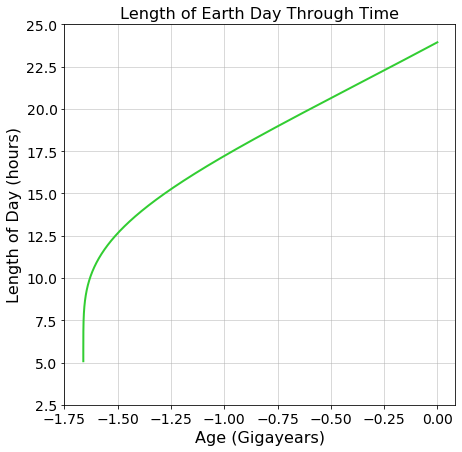

In [49]:
o_e_t = sol_SE / i_e # Angular velocity (omega) of Earth at a given time
lod_t = (2*np.pi) / o_e_t # Length of Earth day at a given time in seconds

plt.plot(t_axis, lod_t/3600, c = 'limegreen', linewidth = 2)
plt.xlabel('Age (Gigayears)')
plt.ylabel('Length of Day (hours)')
plt.title('Length of Earth Day Through Time')
plt.grid(alpha = 0.6)
plt.xlim(-1.75,)
plt.ylim(2.5, 25)
plt.savefig("lod.pdf")

### Step 8: Finding length of day during Moon formation

In [47]:
roche = 6378137 / 1000 # Earth's Roche radius in km

print('Earth-Moon Roche Radius =', roche)

print("By extrapolating, the initial distance was = ", lod_t[-1]/3600)

Earth-Moon Roche Radius = 6378.137
By extrapolating, the initial distance was =  5.076798685827165
